# Student Dropouts - Exploratory Data Analysis

The aim of this project is to analyse the dataset to identify it's main characteristics and identify patterns. Any outliers should be identified and missing values imputated. I would like to display these discoveries visually.

TfL is known for being very busy

## The Dataset
https://www.kaggle.com/datasets/astronasko/transport-for-london-journey-information

This Dataset describes 5% of all journies on various TfL (Transport for London) modes of transport that were made using Oyster Card in a week in November 2009.

Use the link above to see the column descriptions

data consists of journies and how they wre paid for.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("Nov09JnyExport.csv")
df.head()

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
0,3,Tue,LUL,Unstarted,Kings Cross M,0,00:00,633,10:33,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
1,4,Wed,LUL,Unstarted,Sudbury Hill,0,00:00,447,07:27,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
2,3,Tue,NR,Unstarted,Richmond,0,00:00,966,16:06,Z0304,TKT,N,0,0,XX,LUL Travelcard-7 Day
3,4,Wed,NR,Unstarted,Romford,0,00:00,657,10:57,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
4,6,Fri,NR,Unstarted,Norwood Junction SR,0,00:00,450,07:30,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day


In [3]:
row_count = len(df)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623487 entries, 0 to 2623486
Data columns (total 16 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   downo         2623487 non-null  int64 
 1   daytype       2623487 non-null  object
 2   SubSystem     2623487 non-null  object
 3   StartStn      2623487 non-null  object
 4   EndStation    2623487 non-null  object
 5   EntTime       2623487 non-null  int64 
 6   EntTimeHHMM   2623487 non-null  object
 7   ExTime        2623487 non-null  int64 
 8   EXTimeHHMM    2623487 non-null  object
 9   ZVPPT         2623487 non-null  object
 10  JNYTYP        2623487 non-null  object
 11  DailyCapping  2623487 non-null  object
 12  FFare         2623487 non-null  int64 
 13  DFare         2623487 non-null  int64 
 14  RouteID       2623487 non-null  object
 15  FinalProduct  2623487 non-null  object
dtypes: int64(5), object(11)
memory usage: 320.3+ MB


The data has 2623487 rows.
The summary above shows that there are no Null values.
I'd be interested in seeing the distributions of Entry Time and Exit Time of the journies.

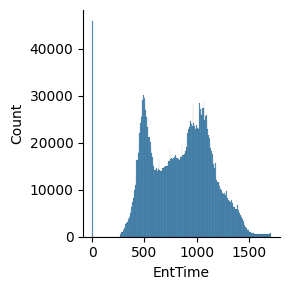

In [4]:
sns.displot(df, x="EntTime", height=3)

Note: EntTime is journey entry time in minutes past midnight

The distribution seems to have 2 spikes. This is likely due to peak hours where passengers are going to or from work.

There appears to be a sharp spike at EntTime = 0. It is not likely that this is due to 40k+ passengers starting their journey at midnight. Instead, I expect that these are journies that were not started.

The number of journies with EntTime = 0 should be similar to the number of unstarted journies.
Unstarted journies are journies that did not start with an oyster card being tapped, but ended with it. This is a mistake on the passenger's part.

In [5]:
ent_time_0_count = len(df[df.EntTime == 0])
unstarted_journey_count = len(df[df.StartStn == "Unstarted"])
print("Number of journies that started at midnight: ", ent_time_0_count)
print("Number of 'unstarted' journies: ", unstarted_journey_count)
print("\'Unstarted\' journies make up {} of all journies ".format(unstarted_journey_count/row_count))

Number of journies that started at midnight:  45989
Number of 'unstarted' journies:  45994
'Unstarted' journies make up 0.01753162870637438 of all journies 


Since the number of unstarted journies make up less than 2% of all journies, it is safe to drop these rows as they are anomalies.

In [6]:
df = df[df.StartStn != "Unstarted"]

I would expect for there to be a large number of rows where 'ExTime' is 0. This is because for bus journies, passengers only tap their Oyster card once to start their journey.

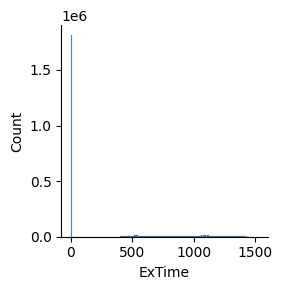

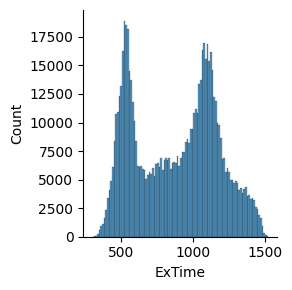

In [7]:
sns.displot(df, x="ExTime", height=3)

# Show a distribution plot of ExTime where we ignore all rows with value 0
sns.displot(df[df.ExTime != 0], x="ExTime", height=3)

There are around 10^6 rows where ExTime is 0. 
When these rows are excluded, the distribution of ExTime is similar to distribution of EntTime (which is expected).
Let's compare the number of ExTime = 0 to the number of bus journies

In [8]:
ex_time_0_count = len(df[df.ExTime == 0])
bus_count = len(df[df.SubSystem == "LTB"])

print("Number of journies with ExTime = 0: ", ex_time_0_count)
print("Number of bus journies: ", bus_count)

Number of journies with ExTime = 0:  1812168
Number of bus journies:  1768080


The number of journies with ExTime=0 is slightly higher than the number of bus journies. I'm curious to see if they can be explained by the number of journies that were unfinished.

In [9]:
unfinished_count = len(df[df.EndStation == "Unfinished"])
print("Number of unfinished journies: ", unfinished_count)

Number of unfinished journies:  35138


In [10]:
print("Number of journies with ExTime = 0: ", ex_time_0_count)
print("Number of bus journies + unfinished journies: ", bus_count + unfinished_count)

Number of journies with ExTime = 0:  1812168
Number of bus journies + unfinished journies:  1803218


It appears that bus journies and unfinished journies explain the majority of journies that have ExTime = 0

### Which Stations do journies start/stop at the most?

In [14]:
start_stations = df[~df.StartStn.isin(["Unstarted", "Bus"])]["StartStn"]
end_stations = df[~df.EndStation.isin(["Unfinished", "Bus"])]["EndStation"]
all_stations = start_stations._append(end_stations, ignore_index=True)
all_stations_count = all_stations.value_counts()
stations_highest_count = all_stations_count.nlargest(7)
stations_lowest_count = all_stations_count.nsmallest(7)

all_stations_count

Oxford Circus                     39409
Victoria                          34836
London Bridge                     32374
Liverpool Street                  30061
Canary Wharf                      23941
                                  ...  
New Cross                            19
Sudbury&Harrow Rd                    12
Bellingham                            3
BLCKHRS LNE TRAM                      2
Harringay                             1
Name: count, Length: 453, dtype: int64

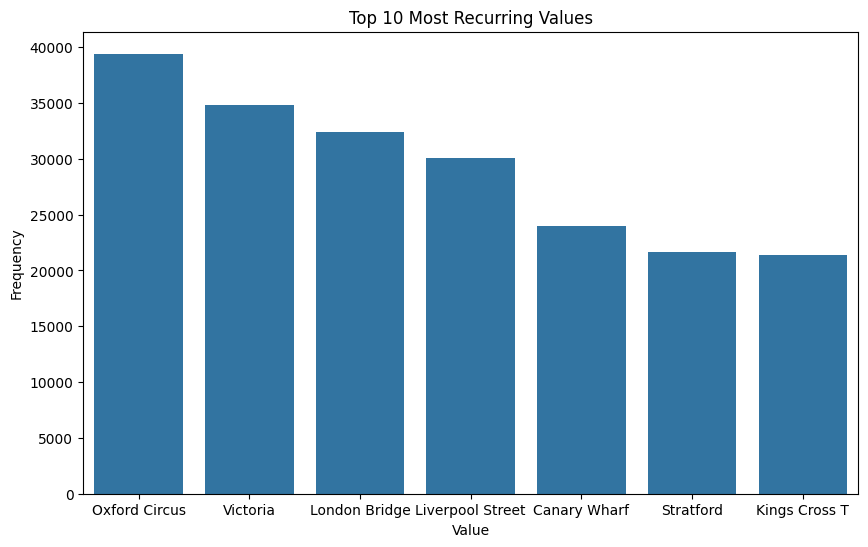

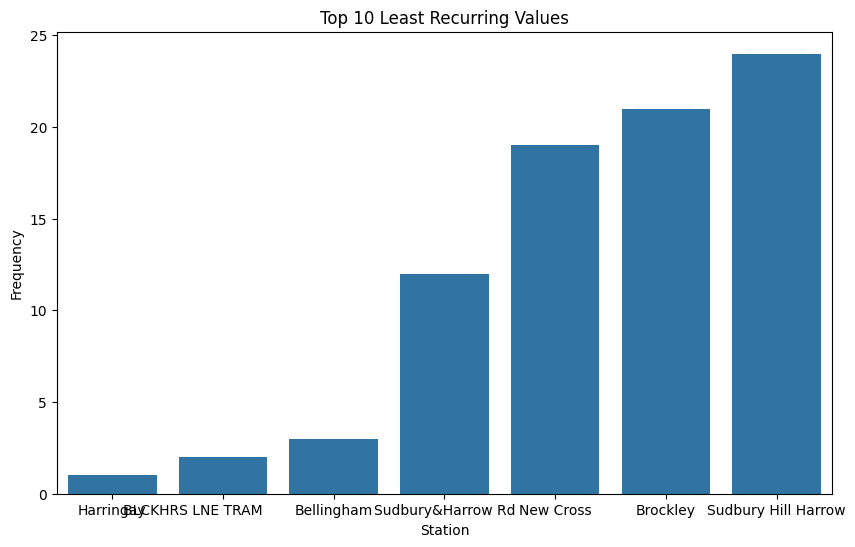

In [18]:
# value_counts_df = value_counts.reset_index()
# value_counts_df.columns = ['Value', 'Frequency']

stations_highest_count_df = stations_highest_count.reset_index()
stations_highest_count_df.columns = ['Station', 'Frequency']

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Station', y='Frequency', data=stations_highest_count_df)
plt.title('Top 10 Most Recurring Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

stations_lowest_count_df = stations_lowest_count.reset_index()
stations_lowest_count_df.columns = ['Station', 'Frequency']

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x='Station', y='Frequency', data=stations_lowest_count_df)
plt.title('Top 10 Least Recurring Values')
plt.xlabel('Station')
plt.ylabel('Frequency')
plt.show()

## How does the number of journies vary by day?

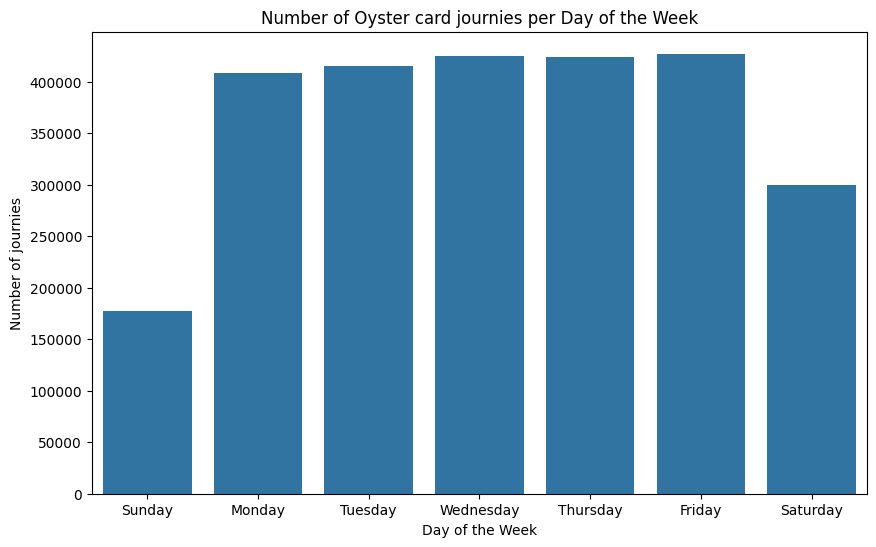

In [26]:
day_counts = df['downo'].value_counts().sort_index().reset_index()

day_names = {2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday', 1: 'Sunday'}
day_counts['day'] = day_counts['downo'].map(day_names)

plt.figure(figsize=(10, 6))
sns.barplot(x='day', y='count', data=day_counts)
plt.title('Number of Oyster card journies per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of journies')
plt.show()

There is little difference in the numer of journies on weekdays. Sunday has less than half the traffic than on weekdays. 

## Product used to pay for journies

There are different types of Oyster cards that passengers can use to pay for their journey. The standard one is Pay as you go. There are also Travel cards which a customer pays for up front and is valid for a certain amount of time among others.

Why is this interesting?
As an employee of TfL it would be useful to see how many of these cards are being used. Whether they need further marketing etc.

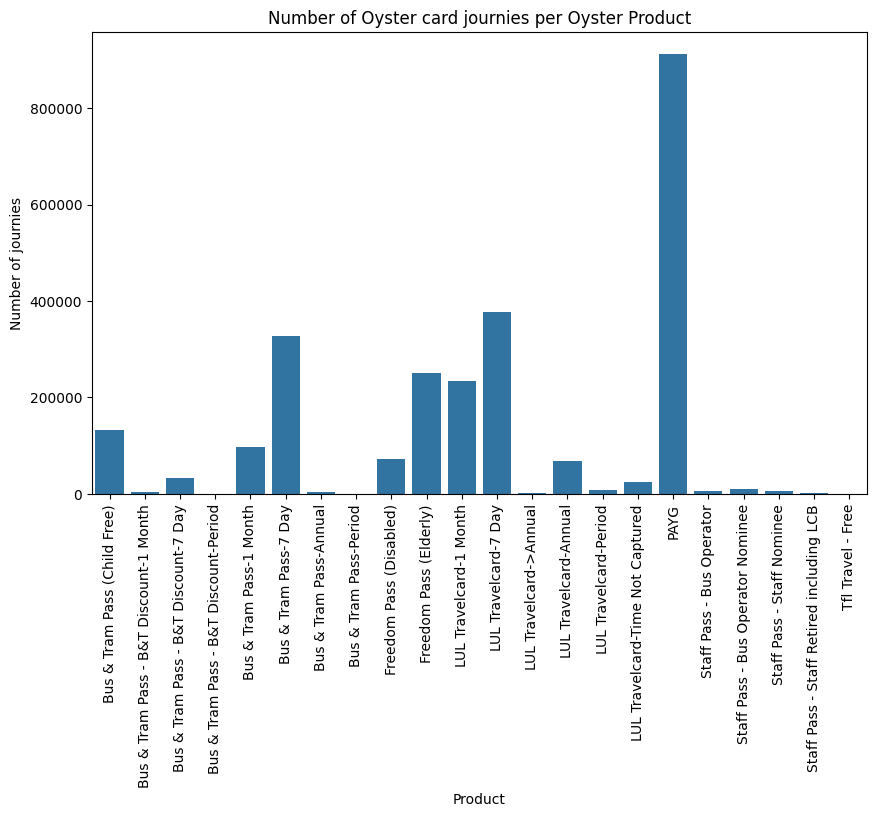

In [30]:
product_counts = df['FinalProduct'].value_counts().sort_index().reset_index()
product_counts

# day_names = {2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday', 1: 'Sunday'}
# day_counts['day'] = day_counts['downo'].map(day_names)

plt.figure(figsize=(10, 6))
sns.barplot(x='FinalProduct', y='count', data=product_counts)
plt.title('Number of Oyster card journies per Oyster Product')
plt.xlabel('Product')
plt.ylabel('Number of journies')
plt.xticks(rotation=90)
plt.show()

In [ ]:
By far the most popular didiwjodek...

## To-Do
- Which stations are used the most
- Distribution of days
- Product used to pay for journey

## Questions I may have as a TfL employee
- Are there any Subsystems that are underutilised during peak hours?
- Which days have the least number of journies?
- Which stations are used the most? Can we direct passengers to nearby, quieter stations during peak hours?

In [ ]:
Notes/ disclaimers
- covid has changed working patterns a lot. probably varies now.
This was before contactless card payments were used.